In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from sdt_dask.clients.aws.fargate_client import FargateClient
from sdt_dask.dataplugs.S3Bucket_plug import S3Bucket
from sdt_dask.dask_tool.runner import Runner

# Import user-defined dataplug

## Pull from S3Bucket

In [3]:
S3Bucket?

Init signature: S3Bucket(bucket_name)
Docstring:     
Dataplug class for retrieving data from an S3 bucket.
aws configurations for the AWS CLI must be set up in local environment
Init docstring:
Initialize the S3Bucket object with the bucket name.

:param bucket_name: The name of the S3 bucket to pull data from
File:           ~/Documents/SLAC/PVInsight/solar-data-tools/sdt_dask/dataplugs/S3Bucket_plug.py
Type:           type
Subclasses:     

In [4]:
bucket_name = "pvinsight-dask-baseline"
s3_data_plug = S3Bucket(bucket_name)
KEYS = s3_data_plug._pull_keys()
KEYS = [(key,) for key in KEYS]
s3_data_plug.get_data(KEYS[0])
KEYS = KEYS[:3] # test only 3 files
KEYS

/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/time_axis_manipulation.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])


[('001C4B0008A5.csv',), ('001C4B001069.csv',), ('0022F2006723.csv',)]

# Initialize the Client

In [5]:
# Use should define an environment variable for secret key
PA_NUMBER = os.getenv("PROJECT_PA_NUMBER")
AWS_DEFAULT_REGION = os.getenv('AWS_DEFAULT_REGION')
ENVIRONMENT = {
    'AWS_ACCESS_KEY_ID' : os.getenv('AWS_ACCESS_KEY_ID'),
    'AWS_SECRET_ACCESS_KEY' : os.getenv('AWS_SECRET_ACCESS_KEY')
}

In [6]:
# The Tag, VPC, image, workers, threads per worker and environment need to be user defined and passed to the client class
TAGS = {
    "project-pa-number": PA_NUMBER,
    "project": "pvinsight"
}
VPC = "vpc-ab2ff6d3" # for us-west-2
IMAGE = "slacgismo/sdt-v1:latest"

WORKERS = 4
THREADS_PER_WORKER = 2

In [7]:
client_setup = FargateClient(image=IMAGE,
                             tags=TAGS,
                             vpc=VPC,
                             region_name=AWS_DEFAULT_REGION,
                             environment=ENVIRONMENT,
                             workers=WORKERS,
                             threads=THREADS_PER_WORKER
                            )
# Dask Local Client Initialization
client = client_setup.init_client()

Initializing Fargate Cluster with 4 workers, 2 threads and 16384MiB per worker...


/opt/miniconda3/envs/pvi-numpy-2/lib/python3.12/contextlib.py:144: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources on AWS. Hang tight! 
  next(self.gen)


Initialized Fargate Cluster
Initializing Dask Client ...
Dask Dashboard Link: http://35.87.187.174:8787/status


/opt/miniconda3/envs/pvi-numpy-2/lib/python3.12/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| lz4     | None   | 4.3.3     | 4.3.3   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


# Use Runner to take in data plug and cluster then run the Dask tasks


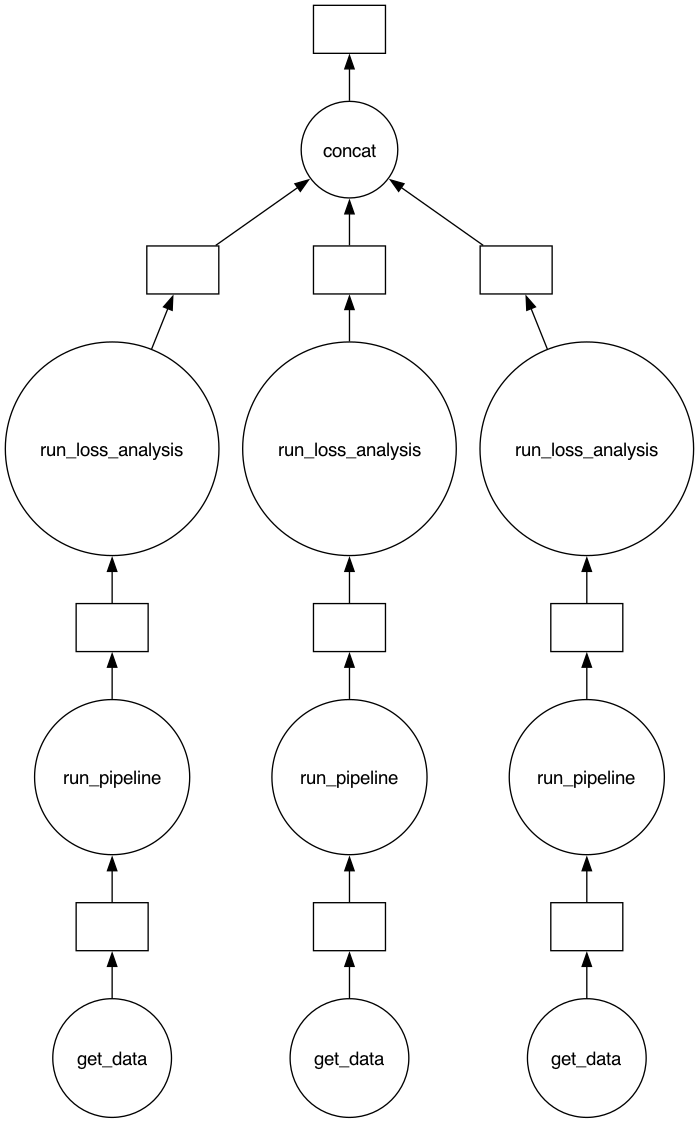

In [8]:
runner = Runner(
    client=client,
    output_path="../result/"
)

runner.set_up(KEYS, data_plug=s3_data_plug, fix_shifts=True, verbose=True)
runner.visualize()

from IPython.display import display, Image
display(Image(filename='sdt_graph.png'))


# Get final result table

In [9]:
runner.get_result()

# The result table and dask report has been saved in the folder you specified in the output_path parameter of the Runner object